### Reproduction of the attack on the 8-th AES round proposed in *Fault Attacks on AES with Faulty Ciphertexts Only*, Thomas Fuhr et al.

DOI: https://doi.org/10.1109/FDTC.2013.18

While CPU implementation can be used, it is discouraged, because it is not parallelized; the attack complexity is 2<sup>32</sup>. Example single threaded CPU implementation is given below, reduced to 2<sup>16</sup> (the attack runs an exhaustive search over 4 bytes, two of the bytes are artificially assumed to be zeros). The 2<sup>32</sup> version can be easily "unlocked", if desired.

The recommended implementations use CUDA. There are two versions, the difference is described further on.

In [ ]:
import functools
import matplotlib.pyplot as plt
import pickle
import random
import sys

from tqdm.notebook import trange

from chipwhisperer.analyzer import aes_funcs

from SimulationUtils import key_schedule, do_round, do_rounds, do_final, shift_row_lookup
from Perturbation import PerturbationStuckAtRandom

sys.path.append("../../pa-tools")

from patools.victims.aes_tools import rev_sbox
from patools.utils.misc import randbytes

import cupy as cp
import numpy as np

In [ ]:
# Notebook settings
%matplotlib notebook

Define a few utilities.

In [ ]:
# Extract a column from a sample as a 32-bit value.
def sample_to_column(sample, column_index):
    sample = aes_funcs.inv_shiftrows(sample.copy())
    first = column_index * 4
    return sample[first] | (sample[first + 1] << 8) | (sample[first + 2] << 16) | (sample[first + 3] << 24)

# Extract the last round key column that is XORed to a faulted column as a 32-bit value.
# We will need it to verify attack results.
def fault_idx_to_key_column(fault_idx, last_key):
    fault_idx_before_mc = shift_row_lookup[fault_idx]
    fault_column = fault_idx_before_mc // 4
    key_idxs = shift_row_lookup[fault_column * 4 : (fault_column + 1) * 4]
    return functools.reduce(lambda x, y: x | y, [last_key[i] << (j * 8) for (j, i) in enumerate(key_idxs)])

The attack targets one column of AES state at the certain point of execution. Thus, for complete key recovery, it either has to be run four times such that in each run a different column is perturbed, or four columns need to be perturbed at once. Perturbance in a column must occur on the same byte for each ciphertext. The attack calculations are independent for each column. They include iteration over four bytes of the last round key affecting their respective column (complexity of one column recovery is 2<sup>32</sup>).

Here, we reproduce the attack on only one column, though the implementation can be easily modified to handle more.

The attack relies on faulting state after AES antepenultimate AddRoundKey. Then, for each "column" round key guess, Smod<sub>9</sub> of a column in which the fault occurred is calculated for each ciphertext. Smod<sub>9</sub> is defined as follows:

Smod<sub>9</sub> = MC<sup>-1</sup> ∘ SB<sup>-1</sup> ∘ SR<sup>-1</sup>(C ⊕ K<sub>10</sub>),

where MC means MixColumns, SB means SubBytes, SR means ShiftRows, C is a ciphertext and K<sub>10</sub> is a key of the final round.

Then, using all Smods for a particular 4-byte key guess, Square Euclidean Imbalance (SEI) of the byte values on the position affected by the faulted byte is calculated. A key guess with the highest SEI is determined as the most probable.

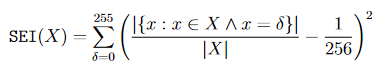

In [ ]:
# Simulate an AES ciphertext faulted after the antepenultimate AddRoundKey
def do_aes_perturb_r8(subkeys, txi, index, perturbation):
    state = do_rounds(subkeys, txi, 8)
    state = perturbation.perturb(state, index)
    state = do_round(subkeys[-2], state)
    return do_final(subkeys[-1], state)

# Generate a bunch of AES ciphertexts faulted at the same byte
def gather(perturbation, subkeys, iterations, fault_idx):
    txos = []
    for i in range(iterations):
        txi = randbytes(16)
        txos.append(do_aes_perturb_r8(subkeys, txi, fault_idx, perturbation))
    return txos

#### Single-threaded CPU attack implementation.

In [ ]:
times9 = [
    0x00,0x09,0x12,0x1b,0x24,0x2d,0x36,0x3f,0x48,0x41,0x5a,0x53,0x6c,0x65,0x7e,0x77,
    0x90,0x99,0x82,0x8b,0xb4,0xbd,0xa6,0xaf,0xd8,0xd1,0xca,0xc3,0xfc,0xf5,0xee,0xe7,
    0x3b,0x32,0x29,0x20,0x1f,0x16,0x0d,0x04,0x73,0x7a,0x61,0x68,0x57,0x5e,0x45,0x4c,
    0xab,0xa2,0xb9,0xb0,0x8f,0x86,0x9d,0x94,0xe3,0xea,0xf1,0xf8,0xc7,0xce,0xd5,0xdc,
    0x76,0x7f,0x64,0x6d,0x52,0x5b,0x40,0x49,0x3e,0x37,0x2c,0x25,0x1a,0x13,0x08,0x01,
    0xe6,0xef,0xf4,0xfd,0xc2,0xcb,0xd0,0xd9,0xae,0xa7,0xbc,0xb5,0x8a,0x83,0x98,0x91,
    0x4d,0x44,0x5f,0x56,0x69,0x60,0x7b,0x72,0x05,0x0c,0x17,0x1e,0x21,0x28,0x33,0x3a,
    0xdd,0xd4,0xcf,0xc6,0xf9,0xf0,0xeb,0xe2,0x95,0x9c,0x87,0x8e,0xb1,0xb8,0xa3,0xaa,
    0xec,0xe5,0xfe,0xf7,0xc8,0xc1,0xda,0xd3,0xa4,0xad,0xb6,0xbf,0x80,0x89,0x92,0x9b,
    0x7c,0x75,0x6e,0x67,0x58,0x51,0x4a,0x43,0x34,0x3d,0x26,0x2f,0x10,0x19,0x02,0x0b,
    0xd7,0xde,0xc5,0xcc,0xf3,0xfa,0xe1,0xe8,0x9f,0x96,0x8d,0x84,0xbb,0xb2,0xa9,0xa0,
    0x47,0x4e,0x55,0x5c,0x63,0x6a,0x71,0x78,0x0f,0x06,0x1d,0x14,0x2b,0x22,0x39,0x30,
    0x9a,0x93,0x88,0x81,0xbe,0xb7,0xac,0xa5,0xd2,0xdb,0xc0,0xc9,0xf6,0xff,0xe4,0xed,
    0x0a,0x03,0x18,0x11,0x2e,0x27,0x3c,0x35,0x42,0x4b,0x50,0x59,0x66,0x6f,0x74,0x7d,
    0xa1,0xa8,0xb3,0xba,0x85,0x8c,0x97,0x9e,0xe9,0xe0,0xfb,0xf2,0xcd,0xc4,0xdf,0xd6,
    0x31,0x38,0x23,0x2a,0x15,0x1c,0x07,0x0e,0x79,0x70,0x6b,0x62,0x5d,0x54,0x4f,0x46
]

times11 = [
    0x00,0x0b,0x16,0x1d,0x2c,0x27,0x3a,0x31,0x58,0x53,0x4e,0x45,0x74,0x7f,0x62,0x69,
    0xb0,0xbb,0xa6,0xad,0x9c,0x97,0x8a,0x81,0xe8,0xe3,0xfe,0xf5,0xc4,0xcf,0xd2,0xd9,
    0x7b,0x70,0x6d,0x66,0x57,0x5c,0x41,0x4a,0x23,0x28,0x35,0x3e,0x0f,0x04,0x19,0x12,
    0xcb,0xc0,0xdd,0xd6,0xe7,0xec,0xf1,0xfa,0x93,0x98,0x85,0x8e,0xbf,0xb4,0xa9,0xa2,
    0xf6,0xfd,0xe0,0xeb,0xda,0xd1,0xcc,0xc7,0xae,0xa5,0xb8,0xb3,0x82,0x89,0x94,0x9f,
    0x46,0x4d,0x50,0x5b,0x6a,0x61,0x7c,0x77,0x1e,0x15,0x08,0x03,0x32,0x39,0x24,0x2f,
    0x8d,0x86,0x9b,0x90,0xa1,0xaa,0xb7,0xbc,0xd5,0xde,0xc3,0xc8,0xf9,0xf2,0xef,0xe4,
    0x3d,0x36,0x2b,0x20,0x11,0x1a,0x07,0x0c,0x65,0x6e,0x73,0x78,0x49,0x42,0x5f,0x54,
    0xf7,0xfc,0xe1,0xea,0xdb,0xd0,0xcd,0xc6,0xaf,0xa4,0xb9,0xb2,0x83,0x88,0x95,0x9e,
    0x47,0x4c,0x51,0x5a,0x6b,0x60,0x7d,0x76,0x1f,0x14,0x09,0x02,0x33,0x38,0x25,0x2e,
    0x8c,0x87,0x9a,0x91,0xa0,0xab,0xb6,0xbd,0xd4,0xdf,0xc2,0xc9,0xf8,0xf3,0xee,0xe5,
    0x3c,0x37,0x2a,0x21,0x10,0x1b,0x06,0x0d,0x64,0x6f,0x72,0x79,0x48,0x43,0x5e,0x55,
    0x01,0x0a,0x17,0x1c,0x2d,0x26,0x3b,0x30,0x59,0x52,0x4f,0x44,0x75,0x7e,0x63,0x68,
    0xb1,0xba,0xa7,0xac,0x9d,0x96,0x8b,0x80,0xe9,0xe2,0xff,0xf4,0xc5,0xce,0xd3,0xd8,
    0x7a,0x71,0x6c,0x67,0x56,0x5d,0x40,0x4b,0x22,0x29,0x34,0x3f,0x0e,0x05,0x18,0x13,
    0xca,0xc1,0xdc,0xd7,0xe6,0xed,0xf0,0xfb,0x92,0x99,0x84,0x8f,0xbe,0xb5,0xa8,0xa3
]

times13 = [
    0x00,0x0d,0x1a,0x17,0x34,0x39,0x2e,0x23,0x68,0x65,0x72,0x7f,0x5c,0x51,0x46,0x4b,
    0xd0,0xdd,0xca,0xc7,0xe4,0xe9,0xfe,0xf3,0xb8,0xb5,0xa2,0xaf,0x8c,0x81,0x96,0x9b,
    0xbb,0xb6,0xa1,0xac,0x8f,0x82,0x95,0x98,0xd3,0xde,0xc9,0xc4,0xe7,0xea,0xfd,0xf0,
    0x6b,0x66,0x71,0x7c,0x5f,0x52,0x45,0x48,0x03,0x0e,0x19,0x14,0x37,0x3a,0x2d,0x20,
    0x6d,0x60,0x77,0x7a,0x59,0x54,0x43,0x4e,0x05,0x08,0x1f,0x12,0x31,0x3c,0x2b,0x26,
    0xbd,0xb0,0xa7,0xaa,0x89,0x84,0x93,0x9e,0xd5,0xd8,0xcf,0xc2,0xe1,0xec,0xfb,0xf6,
    0xd6,0xdb,0xcc,0xc1,0xe2,0xef,0xf8,0xf5,0xbe,0xb3,0xa4,0xa9,0x8a,0x87,0x90,0x9d,
    0x06,0x0b,0x1c,0x11,0x32,0x3f,0x28,0x25,0x6e,0x63,0x74,0x79,0x5a,0x57,0x40,0x4d,
    0xda,0xd7,0xc0,0xcd,0xee,0xe3,0xf4,0xf9,0xb2,0xbf,0xa8,0xa5,0x86,0x8b,0x9c,0x91,
    0x0a,0x07,0x10,0x1d,0x3e,0x33,0x24,0x29,0x62,0x6f,0x78,0x75,0x56,0x5b,0x4c,0x41,
    0x61,0x6c,0x7b,0x76,0x55,0x58,0x4f,0x42,0x09,0x04,0x13,0x1e,0x3d,0x30,0x27,0x2a,
    0xb1,0xbc,0xab,0xa6,0x85,0x88,0x9f,0x92,0xd9,0xd4,0xc3,0xce,0xed,0xe0,0xf7,0xfa,
    0xb7,0xba,0xad,0xa0,0x83,0x8e,0x99,0x94,0xdf,0xd2,0xc5,0xc8,0xeb,0xe6,0xf1,0xfc,
    0x67,0x6a,0x7d,0x70,0x53,0x5e,0x49,0x44,0x0f,0x02,0x15,0x18,0x3b,0x36,0x21,0x2c,
    0x0c,0x01,0x16,0x1b,0x38,0x35,0x22,0x2f,0x64,0x69,0x7e,0x73,0x50,0x5d,0x4a,0x47,
    0xdc,0xd1,0xc6,0xcb,0xe8,0xe5,0xf2,0xff,0xb4,0xb9,0xae,0xa3,0x80,0x8d,0x9a,0x97
]

times14 = [
    0x00,0x0e,0x1c,0x12,0x38,0x36,0x24,0x2a,0x70,0x7e,0x6c,0x62,0x48,0x46,0x54,0x5a,
    0xe0,0xee,0xfc,0xf2,0xd8,0xd6,0xc4,0xca,0x90,0x9e,0x8c,0x82,0xa8,0xa6,0xb4,0xba,
    0xdb,0xd5,0xc7,0xc9,0xe3,0xed,0xff,0xf1,0xab,0xa5,0xb7,0xb9,0x93,0x9d,0x8f,0x81,
    0x3b,0x35,0x27,0x29,0x03,0x0d,0x1f,0x11,0x4b,0x45,0x57,0x59,0x73,0x7d,0x6f,0x61,
    0xad,0xa3,0xb1,0xbf,0x95,0x9b,0x89,0x87,0xdd,0xd3,0xc1,0xcf,0xe5,0xeb,0xf9,0xf7,
    0x4d,0x43,0x51,0x5f,0x75,0x7b,0x69,0x67,0x3d,0x33,0x21,0x2f,0x05,0x0b,0x19,0x17,
    0x76,0x78,0x6a,0x64,0x4e,0x40,0x52,0x5c,0x06,0x08,0x1a,0x14,0x3e,0x30,0x22,0x2c,
    0x96,0x98,0x8a,0x84,0xae,0xa0,0xb2,0xbc,0xe6,0xe8,0xfa,0xf4,0xde,0xd0,0xc2,0xcc,
    0x41,0x4f,0x5d,0x53,0x79,0x77,0x65,0x6b,0x31,0x3f,0x2d,0x23,0x09,0x07,0x15,0x1b,
    0xa1,0xaf,0xbd,0xb3,0x99,0x97,0x85,0x8b,0xd1,0xdf,0xcd,0xc3,0xe9,0xe7,0xf5,0xfb,
    0x9a,0x94,0x86,0x88,0xa2,0xac,0xbe,0xb0,0xea,0xe4,0xf6,0xf8,0xd2,0xdc,0xce,0xc0,
    0x7a,0x74,0x66,0x68,0x42,0x4c,0x5e,0x50,0x0a,0x04,0x16,0x18,0x32,0x3c,0x2e,0x20,
    0xec,0xe2,0xf0,0xfe,0xd4,0xda,0xc8,0xc6,0x9c,0x92,0x80,0x8e,0xa4,0xaa,0xb8,0xb6,
    0x0c,0x02,0x10,0x1e,0x34,0x3a,0x28,0x26,0x7c,0x72,0x60,0x6e,0x44,0x4a,0x58,0x56,
    0x37,0x39,0x2b,0x25,0x0f,0x01,0x13,0x1d,0x47,0x49,0x5b,0x55,0x7f,0x71,0x63,0x6d,
    0xd7,0xd9,0xcb,0xc5,0xef,0xe1,0xf3,0xfd,0xa7,0xa9,0xbb,0xb5,0x9f,0x91,0x83,0x8d
]

def inv_mc(d0, d1, d2, d3):
    b0 = times14[d0] ^ times11[d1] ^ times13[d2] ^ times9[d3]
    b1 = times9[d0]  ^ times14[d1] ^ times11[d2] ^ times13[d3]    
    b2 = times13[d0] ^ times9[d1]  ^ times14[d2] ^ times11[d3]    
    b3 = times11[d0] ^ times13[d1] ^ times9[d2]  ^ times14[d3]    
    return (b0, b1, b2, b3)

def compute_smod9(sample, column, index):
    b0 = column & 0xff
    b1 = (column >> 8) & 0xff
    b2 = (column >> 16) & 0xff
    b3 = (column >> 24) & 0xff
    sample = aes_funcs.inv_shiftrows(sample.copy())
    column_start = (index // 4) * 4
    s0 = rev_sbox[b0 ^ sample[column_start]]
    s1 = rev_sbox[b1 ^ sample[column_start + 1]]
    s2 = rev_sbox[b2 ^ sample[column_start + 2]]
    s3 = rev_sbox[b3 ^ sample[column_start + 3]]
    
    return inv_mc(s0, s1, s2, s3)

def sei_with_guess(samples, index, guess):
    buckets = [0] * 256
    
    for sample in samples:
        buckets[compute_smod9(sample, guess, index)[index % 4]] += 1
    samples_total = len(samples)
    sei = 0
    for b in buckets:
        # 0.00390625 = 1 / 256
        sei += pow(b / samples_total - 0.00390625, 2)
    return sei

Since CPU implementation is slow, a guess range is limited to 16 bits and the remaining 16 bits are assumed to be zeroes (thus, if, for example, the first column is faulted, only keys such that byte 10 and 7 in the last round key is 0 can be recovered). If one wishes to run the attack without this limitation, guess space can be extended by modifying `guess` range in the function below.

In [ ]:
def d_sei_cpu(samples, index):
    max_sei = 0
    best_guess = None
    # Modify the range below for a bigger or a smaller key space
    for guess in trange(256*256):
        sei = sei_with_guess(samples, index, guess)
        if sei > max_sei:
            max_sei = sei
            best_guess = guess
    return best_guess

Run the attack. A master key is chosen such that two fixed bytes of the last round key are zeroes, the indices of these bytes depend on the faulted column. While this is not a case for the overwhelming majority of real-world AES keys, we do it to give the chance to the CPU key guess search to succeed in a reasonable time.

In [ ]:
def get_two_zeros_key(fault_idx):
    rk = bytearray(randbytes(16))
    column = shift_row_lookup[fault_idx] // 4
    if column == 0:
        rk[10] = 0
        rk[7] = 0
    elif column == 1:
        rk[14] = 0
        rk[11] = 0
    elif column == 2:
        rk[2] = 0
        rk[15] = 0
    else:
        rk[6] = 0
        rk[3] = 0
    return aes_funcs.key_schedule_rounds(bytes(rk), 10, 0)
    

def launch_attack_cpu(perturbation, fault_idx, iterations):
    # Get a random key with desired properties
    key = get_two_zeros_key(fault_idx)
    
    # Run AES encryptions
    subkeys = key_schedule(key)
    txos = gather(perturbation, subkeys, iterations, fault_idx)
    
    # Run SEI distinguisher
    best_guess = d_sei_cpu(txos, shift_row_lookup[fault_idx])
    return best_guess == fault_idx_to_key_column(fault_idx, subkeys[-1])

In [ ]:
perturbation = PerturbationStuckAtRandom()
success = launch_attack_cpu(perturbation, random.randint(0, 15), 100)
print('Attack', 'succeeded.' if success else 'failed.')

#### Parallel GPU attack implementation.

The implementation CPU-iterates over one byte of the last round key (out of 4 bytes affecting the attacked column). In each iteration, calculation of SEI for 2<sup>24</sup> combinations of the remaining three bytes guesses is launched with a CUDA kernel. Then, a reduction kernel is used to extract a guess with the highest SEI. The value is stored as an iteration result. After all of 256 iterations, the best result is selected among the iterations results.

There are two CUDA kernels defined. The slightly faster, default kernel, does not provide a strong guarantee that the algorithm will work correctly for more than 255 ciphertexts due to overflowing 8-bit counters that count occurrence of each byte value of the attacked Smod byte (see SEI definition a few cells above for the reference). For (an extreme) example, take 256 ciphertexts. It may happen that the fault causes all counted byte values of 256 ciphertexts to be the same. Then, the counter for this byte overflows to 0 and is equal to all other counters, making the attack fail.

The other kernel detects the overflow and applies maximum "score" to a guess that caused the overflow regardless of calculated SEI value (which is incorrect when the overflow occurs anyway). Note that when the guess is incorrect, the bytes used to compute SEI should be distributed uniformly. The probability of the incorrect guess erroneously triggering the maximum "score" depends on the number of faulted ciphertexts. The upper bound of the probability of this event is presented in the cell below. Refer to **overflow-probs.jl** script for more details on the upper bound calculation method.

In [ ]:
def plot_probabilities(fignum, data, is_log):
    plt.figure(fignum)
    plt.title('Logarithmic scale' if is_log else 'Linear scale')
    plt.yscale('log' if is_log else 'linear')
    plt.xlabel('Number of ciphertexts')
    plt.ylabel('Overflow probability upper bound')
    plt.plot(np.maximum(0, np.minimum(data, 1)))
    plt.grid()
    plt.show()

overflow_probs = np.memmap('overflow_probs/upper_bounds.bin', dtype='float64', mode='r', shape=(64001,))
plot_probabilities(0, overflow_probs, True)
plot_probabilities(1, overflow_probs, False)

In [ ]:
device = cp.cuda.Device(0)
max_threads_per_block = device.attributes['MaxThreadsPerBlock']
shared_mem_per_block = device.attributes['MaxSharedMemoryPerBlock']

In [ ]:
rsbox_times9  = [times9[x]  for x in rev_sbox]
rsbox_times11 = [times11[x] for x in rev_sbox]
rsbox_times13 = [times13[x] for x in rev_sbox]
rsbox_times14 = [times14[x] for x in rev_sbox]
row_sboxes = {
    0 : rsbox_times14 + rsbox_times11 + rsbox_times13 + rsbox_times9,
    1 : rsbox_times9  + rsbox_times14 + rsbox_times11 + rsbox_times13,
    2 : rsbox_times13 + rsbox_times9  + rsbox_times14 + rsbox_times11,
    3 : rsbox_times11 + rsbox_times13 + rsbox_times9  + rsbox_times14
}

def get_sei_kernel(samples, guess_range, row_index, block_size, detect_overflow):
    return cp.RawKernel('''
    #define BLOCK_SIZE ''' + str(block_size) + '''
    #define GUESS_RANGE ''' + str(guess_range) + '''
    #define NSAMPLES ''' + str(len(samples)) + '''
    #define byte(x, n)    ((x >> (8 * n)) & 0xff)
    #define rbox(x, n)    (rbox_s[byte(x, n) + n * 256])
    
    typedef unsigned char uint8_t;
    typedef unsigned int uint32_t;
    typedef unsigned long long uint64_t;
    #define ULONG_MAX 0xffffffffffffffff;
    
    typedef uint8_t freq_t;
    
    __constant__ uint8_t rbox_c[1024] = {
        ''' + ', '.join([str(x) for x in row_sboxes[row_index]]) + '''
    };
    
    __constant__ uint32_t samp_c[] = {
        ''' + ', '.join([str(s) for s in samples]) + '''
    }; 
    
    // Samples must be 4-byte-packed columns processed with inverse ShiftRows beforehand.
    extern "C" 
    __global__ void sei_gpu_overflow(uint32_t guess_high, uint64_t* results) {
        __shared__ uint8_t rbox_s[1024];
        __shared__ freq_t freq_s[256][BLOCK_SIZE];
        
        auto tidx = threadIdx.x;
        
        // Copy lookups to shared memory
        for(auto i = threadIdx.x; i < sizeof(rbox_c) / sizeof(uint32_t); i += blockDim.x) {
            ((uint32_t*)rbox_s)[i] = ((uint32_t*)rbox_c)[i];
        }        
        
        // Prepare a container for faulted byte frequency statistics
        for(auto i = 0; i < 256; i++) {
            freq_s[i][tidx] = 0;
        }
        
        uint32_t gid = blockIdx.x * blockDim.x + threadIdx.x;
        
        while(gid < GUESS_RANGE) {
            __syncthreads();
            auto guess = guess_high + gid;
            
            // Iterate over ciphertexts
            for(auto i = 0; i < NSAMPLES; i++) {
                // Reverse the state back to Smod
                uint32_t ark = guess ^ samp_c[i];
                uint8_t  idx = rbox(ark, 0) ^ rbox(ark, 1) ^ rbox(ark, 2) ^ rbox(ark, 3);
                // Update frequency statistics based on the result byte
                freq_s[idx][tidx]++;
            }
            // Compute SEI numerator based on obtained frequency statistics
            // (denominator is common for all the guesses, so it can be omitted)
            ''' + ('uint32_t total = 0;' if detect_overflow else '') + '''       
            uint64_t sei_numerator = 0;
            for(auto i = 0; i < 256; i++) {
                ''' + ('total += freq_s[i][tidx];' if detect_overflow else '') + '''
                uint64_t diff = 256ULL * freq_s[i][tidx] - NSAMPLES;
                sei_numerator += diff * diff;
            }''' + ('''
            if(total != NSAMPLES) {
                // Overflow detected! The guess is assigned the maximum "score"
                results[gid] = ULONG_MAX;
            } else {
                results[gid] = sei_numerator;
            }
            ''' if detect_overflow else '''
            results[gid] = sei_numerator;
            ''') + '''
            // Prepare counters for the next iteration
            for(auto i=0; i < 256; i++) {
                freq_s[i][tidx] = 0;
            }
            gid += gridDim.x * blockDim.x;
        }
    }
    ''', 'sei_gpu_overflow', ('-std=c++14',))

max_gpu_kernel = cp.RawKernel('''
    typedef unsigned long long uint64_t;
    extern "C" 
    __global__ void max_gpu(const uint64_t* sei_numerators, unsigned* maxes, unsigned* maxes_reduced) {
        __shared__ unsigned block_maxes[''' + str(max_threads_per_block) + '''];

        int tid = threadIdx.x;
        int bid = blockIdx.x;
        int gid = blockDim.x * bid + tid;

        block_maxes[tid] = maxes[gid];
        __syncthreads();

        // Calculate max within this block
        for(unsigned s = (blockDim.x >> 1); s > 0; s >>= 1) {
            if(tid < s) {
                unsigned left = block_maxes[tid];
                unsigned right = block_maxes[tid + s];
                block_maxes[tid] = sei_numerators[left] > sei_numerators[right] ? left : right;
            }
            __syncthreads();
        }

        if(tid == 0) {
            maxes_reduced[bid] = block_maxes[0];
        }
}
''', 'max_gpu', ('-std=c++14',))

In [ ]:
# Extract maximal SEI from the collection.
# A few launches are required to avoid issues with the lack of synchronization between the blocks.
def run_max_gpu(seis):
    guess_range = len(seis)
    maxes = cp.arange(guess_range, dtype=np.uint32)
    
    while True:
        len_maxes = len(maxes)
        no_threads = len_maxes if len_maxes < max_threads_per_block else max_threads_per_block
        no_blocks = len_maxes // no_threads
        
        maxes_reduced = cp.empty(no_blocks, dtype=np.uint32)
        max_gpu_kernel((no_blocks,), (no_threads,), (seis, maxes, maxes_reduced))
        
        if no_blocks < 2:
            return maxes_reduced
        
        maxes = maxes_reduced

# Run GPU SEI calculation for 2^24 guesses (one byte is fixed and is passed to the function as a parameter).
def partial_sei_gpu(kernel, guess_range, key_msb, no_threads, no_blocks):
    high = key_msb << 24
    seis = cp.zeros(guess_range, dtype=np.uint64)
    kernel((no_blocks,),(no_threads,),(cp.uint32(high), seis))
    return seis

# GPU SEI distinguisher
def d_sei_gpu(txos, index, **kwargs):
    detect_overflow = kwargs.get('detect_overflow', True)
    sei_no_threads = kwargs.get('sei_no_threads', None)
    sei_no_blocks = kwargs.get('sei_no_blocks', None)
    
    column_index = index // 4
    row_index = index % 4
    guess_range = 256*256*256
    samples = cp.array([sample_to_column(txo, column_index) for txo in txos], dtype=np.uint32)
    
    # 1024 + 256 * block_size < shared_memory_per_block
    # shared_memory_per_block is a multiple of 1024
    sei_kernel_max_block = (shared_mem_per_block - 1024) // 256
    if sei_no_threads is None:
        no_threads = sei_kernel_max_block
    elif sei_no_threads > sei_kernel_max_block:
        raise ValueError(f'Too many threads per block, max: {sei_kernel_max_block}')
    else:
        no_threads = sei_no_threads
    no_blocks = 128 if sei_no_blocks is None else sei_no_blocks
            
    kernel = get_sei_kernel(samples, guess_range, row_index, no_threads, detect_overflow)
    
    len_samples = len(samples)
    
    best_guess = None
    best_sei = 0.
    for key_msb in trange(256):
        seis = partial_sei_gpu(kernel, guess_range, key_msb, no_threads, no_blocks)
        maxes = run_max_gpu(seis)
        best_guess_part = maxes[0].get() 
        best_sei_part = seis[best_guess_part].get()
        if best_sei_part > best_sei:
            best_sei = best_sei_part
            best_guess = best_guess_part | (key_msb << 24)
        
    return best_guess

Run the attack targeting four bytes of AES last round key.

In [ ]:
def launch_attack_gpu(perturbation, fault_idx, iterations, **kwargs):
    key = bytearray(randbytes(16))
    subkeys = key_schedule(key)
    txos = gather(perturbation, subkeys, iterations, fault_idx)
    best_guess = d_sei_gpu(txos, shift_row_lookup[fault_idx], **kwargs)
    last_key = subkeys[-1]
    return best_guess == fault_idx_to_key_column(fault_idx, last_key)

In [ ]:
perturbation = PerturbationStuckAtRandom()

success = launch_attack_gpu(perturbation, random.randint(0, 15), 120, **{'detect_overflow':False})
print('Attack without overflow detection', 'succeeded.' if success else 'failed.')
    
success = launch_attack_gpu(perturbation, random.randint(0, 15), 120, **{'detect_overflow':True})
print('Attack with overflow detection', 'succeeded.' if success else 'failed.')

#### Success rates for "stuck at random" perturbation  

In order to determine the success rate of the attack, the procedure has been run 1000 times for each number of random faulted ciphertexts from 1 to 120. Each time the choice of a faulted index was random. Since the number of ciphertexts never exceeded 255, no overflow detection was needed. The data to plot the success rate graph is provided in *r8_probs/r8_random_count* file. 

The code used to obtain the results is given below. In order to rerun the experiment, change `run_experiment` variable value to `True`. Keep in mind that the calculations may take a **significant** amount of time, even with a top tier hardware!

In [ ]:
run_experiment = False
override_data = False
max_ciphertexts = 120

In [ ]:
def read_pickled_results():
    success_rates = [0.]
    for ctxs in range(1, max_ciphertexts + 1):
        with open(f'r8_probs/r8_random{ctxs}', 'rb') as f:
            success_rates.append(pickle.load(f).count(True) / 1000)
    return success_rates

def plot_success_rates(fignum, rerun=False):
    if rerun:
        success_rates = read_pickled_results()
    else:
        with open(f'r8_probs/packed_r8_random', 'rb') as f:
            success_rates = pickle.load(f)

    plt.figure(fignum)
    plt.ylabel('Success rate')
    plt.xlabel('Number of ciphertexts')
    plt.plot(success_rates)
    plt.grid()
    plt.show()

In [ ]:
if run_experiment:
    perturbation = PerturbationStuckAtRandom()
    for ctxs in trange(1, max_ciphertexts + 1):
        with open(f'r8_probs/r8_random{ctxs}', 'wb') as f:
            pickle.dump([launch_attack_gpu(perturbation, random.randint(0, 15), ctxs) for _ in trange(1000)], f)

In [ ]:
if run_experiment and override_data:
    success_rates = read_pickled_results()
    with open(f'r8_probs/packed_r8_random', 'wb') as f:
        pickle.dump(success_rates, f)

In [ ]:
plot_success_rates(2, run_experiment)

#### Run the attack for supplied ciphertexts

Here, we provide a full implementation of the attack on a user-supplied ciphertexts.
The ciphertexts can be supplied in four files (one for each column). If all the files are supplied, the recovered last round key will be reversed to respective AES encryption key.

Fault index to column translation:

| Fault index   | Fault column  |
| ------------- |---------------|
| 0             | 0             |
| 1             | 3             |
| 2             | 2             |
| 3             | 1             |
| 4             | 1             |
| 5             | 0             |
| 6             | 3             |
| 7             | 2             |
| 8             | 2             |
| 9             | 1             |
| 10            | 0             |
| 11            | 3             |
| 12            | 3             |
| 13            | 2             |
| 14            | 1             |
| 15            | 0             |

Uses `CtxSerializer` from **ctx_serializer.py** file to load ciphertexts.

All data is in hexadecimal format, with no bytes/words separators.

If `last_round_key_saved` is `True`, `CtxSerializer` will interpret the first line in the supplied file as a reference last round key.

Variable `data` should contain tuples specifying a serialized ciphertexts file and a fault index.

As for our example, we use data gathered with ChipWhisperer clock glitches on STM32F3 device, targetting mbedTLS AES encryption (hex file can be found in **AES/victims** directory).
For exact glitch parameters, see **STM32F3Faulter** in **AES/faults/glitch-gen** directory.

In [ ]:
last_round_key_saved = True
data = [
    # First column
    ('faults_STM32F3_mbedTLS/faulted_STM32_Fuhr_r8_b10', 10),
    # Second column
    ('faults_STM32F3_mbedTLS/faulted_STM32_Fuhr_r8_b3', 3),
    # Third column
    ('faults_STM32F3_mbedTLS/faulted_STM32_Fuhr_r8_b13', 13),
    # Fourth column
    ('faults_STM32F3_mbedTLS/faulted_STM32_Fuhr_r8_b1', 1)
]
detect_overflow = False

In [ ]:
sys.path.append("..")
from ctx_serializer import CtxSerializer

def order_key_bytes(fault_column, key_bytes):
    key = [None] * 16
    if key_bytes:
        key_idxs = shift_row_lookup[fault_column * 4 : (fault_column + 1) * 4]
        for i, j in enumerate(key_idxs):
            key[j] = (key_bytes >> (i * 8)) & 0xff
    return key
    

def launch_supplied_full(data, last_round_key_saved, **kwargs):
    res_cols = [None] * 4
    last_key = None

    for filename, fault_idx in data:
        config = CtxSerializer()
        config.save_last_round_key = last_round_key_saved
        config.use_single_plaintext = False
        data = config.load(filename)
        txos = [[b for b in pair[1]] for pair in data['ciphertexts']]
        
        if last_round_key_saved:
            if last_key:
                if last_key != data['key']:
                    raise Exception('Last round keys in supplied files mismatch.')
            else:
                last_key = data['key']

        fault_idx_before_mc = shift_row_lookup[fault_idx]
        fault_column = fault_idx_before_mc // 4
        
        print(f'Attacking column {fault_column}...')
        best_guess = d_sei_gpu(txos, shift_row_lookup[fault_idx], **kwargs)
        success = None
        if last_key:
            success = best_guess == fault_idx_to_key_column(fault_idx, last_key)
            print('Attack on column', fault_column, 'succeeded.' if success else 'failed.')
        if res_cols[fault_column]:
            print(f'Warning: multiple files for column {fault_column} specified - results will be overwritten')
        res_cols[fault_column] = best_guess

    
    col_bytes = [order_key_bytes(c, bg) for (c, bg) in enumerate(res_cols)]
    obtained_key = functools.reduce(lambda a, b: tuple(u if v is None else v for u, v in zip(a, b)), col_bytes)
    print('Obtained last round key:      ', ''.join([f'{b:02x}' if b else '--' for b in obtained_key]))
    
    if all(res_cols):
        encryption_key = aes_funcs.key_schedule_rounds(obtained_key, 10, 0)
        print('Calculated AES encryption key:', ''.join([f'{b:02x}' for b in encryption_key]))

In [ ]:
launch_supplied_full(data, last_round_key_saved, **{'detect_overflow': detect_overflow})

### Legal

The code is published under MIT license (SPDX-License-Identifier: MIT), see [LICENSE](../../../LICENSE).
The project has been cofounded by Polish National Centre for Research and Development (NCBR) under project "Evaluation of Side Channel Attack Potential on Embedded Targets (ESCAPE)", proj. sign. PL-TW/VII/5/2020.